In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from xgboost import plot_tree, plot_importance
import xgboost

from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE

In [2]:
# 匯入資料、處理、正規化
# 讀取完整csv檔
# csv = 'after_select_ft_final30s.csv'
# t = 3000
csv = 'after_select_ft_final3s.csv'
t = 30000
# csv = 'finalcsv30s.csv'
df_3s = pd.read_csv(f'./finalcsv/{csv}' , index_col=0)

df_3s = df_3s.dropna()
df_3s = df_3s.drop(columns = ['songid','videoname','url'])
df_3s_label = df_3s['label']

# 將label字串轉成數字的類別0-9
df_3s['label']=df_3s['label'].replace(['blues','classical','country','disco','hiphop','jazz','metal','pop'
,'reggae','rock'],[0,1,2,3,4,5,6,7,8,9])
# 將song_name欄位丟掉
df_3s = df_3s.drop(['song_name'], axis=1)

# 分成特徵欄位及預測目標欄位
y = df_3s['label']
X = df_3s.loc[:, df_3s.columns != 'label'] # label以外的欄位

# y = test_df['label']
# X = test_df.loc[:, test_df.columns != 'label'] # label以外的欄位
#### NORMALIZE X ####

# 對特徵值做標準化
cols = X.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)

# 新dataframe用標準化過的特徵值
X = pd.DataFrame(np_scaled, columns = cols)

In [3]:
# 切成訓練集合測試集
X_sf, X_tsf, y_sf, y_tsf = train_test_split(X, y, test_size=0.0001)#, random_state=5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)#, random_state=5)

In [4]:
# 定義執行模型的函數，才不用多打很多次
def model_assess(model, title = "Default"):
    model.fit(X_train, y_train)   # 訓練模型
    preds = model.predict(X_test)  # 測試模型
    #print(confusion_matrix(y_test, preds))
    print('Accuracy', title, ':', round(accuracy_score(y_test, preds), 5), '\n')  # print出模型準確率
    return model
# KNN
# knn = KNeighborsClassifier(n_neighbors=2)
# model_assess(knn, "KNN")

# Random Forest
# rforest = RandomForestClassifier(n_estimators=500, max_depth=10, max_features='sqrt')
# model_assess(rforest, "Random Forest")

# Cross Gradient Booster
# xgb = XGBClassifier(n_estimators=300, learning_rate=0.2)
# xgb_model = model_assess(xgb, "Cross Gradient Booster")


In [5]:
# PCA 降維
# pca = PCA(n_components=2)
# scaled_df = pca.fit_transform(X)

# df_p = pd.DataFrame(data = scaled_df, columns = ['pca1', 'pca2'])
# df_p = df_p.reset_index(drop=True)
# tt = pd.DataFrame(y)
# tt = tt.reset_index(drop=True)
# df_p = pd.concat([df_p, tt], axis =1)

# y_p = df_p['label']
# X_p = df_p.loc[:, df_p.columns != 'label'] # label以外的欄位
# X_train, X_test, y_train, y_test = train_test_split(X_p, y_p, test_size=0.1, random_state=42)

In [6]:
# TSNE 降維
# tsne = TSNE(n_components=3)#, random_state=0)
# t_xd = tsne.fit_transform(X)

# df_t = pd.DataFrame(t_xd)
# df_t = df_t.reset_index(drop=True)
# tmp = pd.DataFrame(y, columns = ['label'])
# tmp = tmp.reset_index(drop=True)
# df_t = pd.concat([df_t, tmp], axis =1)

# y_t = df_t['label']
# X_t = df_t.loc[:, df_t.columns != 'label'] # label以外的欄位
# X_train, X_test, y_train, y_test = train_test_split(X_t, y_t, test_size=0.1, random_state=42)

In [21]:
# xgboost 設定
n = 600
l_r = 0.15
# eval_metric ='mlogloss'
eval_metric =['merror','mlogloss']
objective='multi:softmax'
num_class=10
params = {'eta':l_r,
         # 'silent':0,
          'objective':objective,
          'num_class':num_class,
          'eval_metric':eval_metric,
          'gamma':0,
          'max_depth':6}

In [23]:
# XGboost 單次訓練模型(繪製矩陣圖、)
evals_result = {}
d_train = xgboost.DMatrix(X_train, y_train)
d_test = xgboost.DMatrix(X_test, y_test)
watchlist = [(d_train, "train"), (d_test, "valid")]
xgb = xgboost.train(params, d_train, evals=watchlist, num_boost_round=n, evals_result=evals_result)
preds = xgb.predict(d_test)
score = accuracy_score(y_test, preds)
print('Accuracy', ':', round(score, 5), '\n')

[0]	train-merror:0.30285	train-mlogloss:1.96226	valid-merror:0.34861	valid-mlogloss:1.98293
[1]	train-merror:0.26212	train-mlogloss:1.74541	valid-merror:0.30963	valid-mlogloss:1.78236
[2]	train-merror:0.24249	train-mlogloss:1.58333	valid-merror:0.29797	valid-mlogloss:1.63518
[3]	train-merror:0.22880	train-mlogloss:1.45366	valid-merror:0.28603	valid-mlogloss:1.51752
[4]	train-merror:0.21871	train-mlogloss:1.34553	valid-merror:0.27601	valid-mlogloss:1.41966
[5]	train-merror:0.20622	train-mlogloss:1.25175	valid-merror:0.26846	valid-mlogloss:1.33614
[6]	train-merror:0.19744	train-mlogloss:1.17157	valid-merror:0.26379	valid-mlogloss:1.26538
[7]	train-merror:0.19116	train-mlogloss:1.10129	valid-merror:0.25981	valid-mlogloss:1.20252
[8]	train-merror:0.18162	train-mlogloss:1.03855	valid-merror:0.25515	valid-mlogloss:1.14728
[9]	train-merror:0.17531	train-mlogloss:0.98313	valid-merror:0.25075	valid-mlogloss:1.09903
[10]	train-merror:0.17033	train-mlogloss:0.93285	valid-merror:0.24911	valid-mlog

[89]	train-merror:0.00772	train-mlogloss:0.12909	valid-merror:0.12792	valid-mlogloss:0.40186
[90]	train-merror:0.00748	train-mlogloss:0.12680	valid-merror:0.12778	valid-mlogloss:0.40017
[91]	train-merror:0.00724	train-mlogloss:0.12500	valid-merror:0.12723	valid-mlogloss:0.39859
[92]	train-merror:0.00690	train-mlogloss:0.12299	valid-merror:0.12709	valid-mlogloss:0.39686
[93]	train-merror:0.00676	train-mlogloss:0.12083	valid-merror:0.12641	valid-mlogloss:0.39478
[94]	train-merror:0.00659	train-mlogloss:0.11910	valid-merror:0.12613	valid-mlogloss:0.39312
[95]	train-merror:0.00631	train-mlogloss:0.11725	valid-merror:0.12654	valid-mlogloss:0.39193
[96]	train-merror:0.00611	train-mlogloss:0.11512	valid-merror:0.12476	valid-mlogloss:0.38973
[97]	train-merror:0.00573	train-mlogloss:0.11333	valid-merror:0.12449	valid-mlogloss:0.38823
[98]	train-merror:0.00563	train-mlogloss:0.11148	valid-merror:0.12366	valid-mlogloss:0.38659
[99]	train-merror:0.00535	train-mlogloss:0.10943	valid-merror:0.12366	

[177]	train-merror:0.00137	train-mlogloss:0.03483	valid-merror:0.10198	valid-mlogloss:0.31150
[178]	train-merror:0.00130	train-mlogloss:0.03432	valid-merror:0.10129	valid-mlogloss:0.31085
[179]	train-merror:0.00130	train-mlogloss:0.03393	valid-merror:0.10102	valid-mlogloss:0.31040
[180]	train-merror:0.00130	train-mlogloss:0.03348	valid-merror:0.10074	valid-mlogloss:0.30963
[181]	train-merror:0.00130	train-mlogloss:0.03305	valid-merror:0.10060	valid-mlogloss:0.30894
[182]	train-merror:0.00130	train-mlogloss:0.03261	valid-merror:0.10143	valid-mlogloss:0.30859
[183]	train-merror:0.00127	train-mlogloss:0.03221	valid-merror:0.10074	valid-mlogloss:0.30800
[184]	train-merror:0.00127	train-mlogloss:0.03180	valid-merror:0.10033	valid-mlogloss:0.30734
[185]	train-merror:0.00127	train-mlogloss:0.03135	valid-merror:0.10005	valid-mlogloss:0.30690
[186]	train-merror:0.00127	train-mlogloss:0.03088	valid-merror:0.10033	valid-mlogloss:0.30627
[187]	train-merror:0.00127	train-mlogloss:0.03049	valid-merr

[265]	train-merror:0.00127	train-mlogloss:0.01312	valid-merror:0.09086	valid-mlogloss:0.27934
[266]	train-merror:0.00127	train-mlogloss:0.01304	valid-merror:0.09058	valid-mlogloss:0.27909
[267]	train-merror:0.00127	train-mlogloss:0.01295	valid-merror:0.09058	valid-mlogloss:0.27906
[268]	train-merror:0.00127	train-mlogloss:0.01284	valid-merror:0.09031	valid-mlogloss:0.27875
[269]	train-merror:0.00127	train-mlogloss:0.01273	valid-merror:0.09031	valid-mlogloss:0.27872
[270]	train-merror:0.00127	train-mlogloss:0.01262	valid-merror:0.09031	valid-mlogloss:0.27847
[271]	train-merror:0.00127	train-mlogloss:0.01253	valid-merror:0.09017	valid-mlogloss:0.27817
[272]	train-merror:0.00127	train-mlogloss:0.01241	valid-merror:0.09017	valid-mlogloss:0.27797
[273]	train-merror:0.00127	train-mlogloss:0.01230	valid-merror:0.09045	valid-mlogloss:0.27781
[274]	train-merror:0.00127	train-mlogloss:0.01221	valid-merror:0.09058	valid-mlogloss:0.27768
[275]	train-merror:0.00127	train-mlogloss:0.01211	valid-merr

[353]	train-merror:0.00127	train-mlogloss:0.00723	valid-merror:0.08592	valid-mlogloss:0.26755
[354]	train-merror:0.00127	train-mlogloss:0.00720	valid-merror:0.08592	valid-mlogloss:0.26754
[355]	train-merror:0.00127	train-mlogloss:0.00715	valid-merror:0.08606	valid-mlogloss:0.26738
[356]	train-merror:0.00127	train-mlogloss:0.00712	valid-merror:0.08578	valid-mlogloss:0.26733
[357]	train-merror:0.00127	train-mlogloss:0.00708	valid-merror:0.08551	valid-mlogloss:0.26714
[358]	train-merror:0.00127	train-mlogloss:0.00704	valid-merror:0.08564	valid-mlogloss:0.26686
[359]	train-merror:0.00127	train-mlogloss:0.00700	valid-merror:0.08537	valid-mlogloss:0.26677
[360]	train-merror:0.00127	train-mlogloss:0.00697	valid-merror:0.08509	valid-mlogloss:0.26670
[361]	train-merror:0.00127	train-mlogloss:0.00693	valid-merror:0.08496	valid-mlogloss:0.26656
[362]	train-merror:0.00127	train-mlogloss:0.00690	valid-merror:0.08523	valid-mlogloss:0.26648
[363]	train-merror:0.00127	train-mlogloss:0.00687	valid-merr

[441]	train-merror:0.00127	train-mlogloss:0.00504	valid-merror:0.08304	valid-mlogloss:0.26094
[442]	train-merror:0.00127	train-mlogloss:0.00502	valid-merror:0.08331	valid-mlogloss:0.26093
[443]	train-merror:0.00127	train-mlogloss:0.00501	valid-merror:0.08331	valid-mlogloss:0.26095
[444]	train-merror:0.00127	train-mlogloss:0.00499	valid-merror:0.08345	valid-mlogloss:0.26088
[445]	train-merror:0.00127	train-mlogloss:0.00498	valid-merror:0.08372	valid-mlogloss:0.26074
[446]	train-merror:0.00127	train-mlogloss:0.00496	valid-merror:0.08372	valid-mlogloss:0.26071
[447]	train-merror:0.00127	train-mlogloss:0.00495	valid-merror:0.08345	valid-mlogloss:0.26069
[448]	train-merror:0.00127	train-mlogloss:0.00493	valid-merror:0.08358	valid-mlogloss:0.26066
[449]	train-merror:0.00127	train-mlogloss:0.00492	valid-merror:0.08372	valid-mlogloss:0.26069
[450]	train-merror:0.00127	train-mlogloss:0.00491	valid-merror:0.08372	valid-mlogloss:0.26060
[451]	train-merror:0.00127	train-mlogloss:0.00490	valid-merr

[529]	train-merror:0.00127	train-mlogloss:0.00404	valid-merror:0.08262	valid-mlogloss:0.25753
[530]	train-merror:0.00127	train-mlogloss:0.00403	valid-merror:0.08304	valid-mlogloss:0.25749
[531]	train-merror:0.00127	train-mlogloss:0.00402	valid-merror:0.08304	valid-mlogloss:0.25752
[532]	train-merror:0.00127	train-mlogloss:0.00401	valid-merror:0.08304	valid-mlogloss:0.25754
[533]	train-merror:0.00127	train-mlogloss:0.00401	valid-merror:0.08276	valid-mlogloss:0.25755
[534]	train-merror:0.00127	train-mlogloss:0.00400	valid-merror:0.08304	valid-mlogloss:0.25757
[535]	train-merror:0.00127	train-mlogloss:0.00399	valid-merror:0.08317	valid-mlogloss:0.25755
[536]	train-merror:0.00127	train-mlogloss:0.00398	valid-merror:0.08331	valid-mlogloss:0.25752
[537]	train-merror:0.00127	train-mlogloss:0.00398	valid-merror:0.08317	valid-mlogloss:0.25755
[538]	train-merror:0.00127	train-mlogloss:0.00397	valid-merror:0.08358	valid-mlogloss:0.25755
[539]	train-merror:0.00127	train-mlogloss:0.00396	valid-merr

[20:20:46] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:20:47] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:20:48] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false

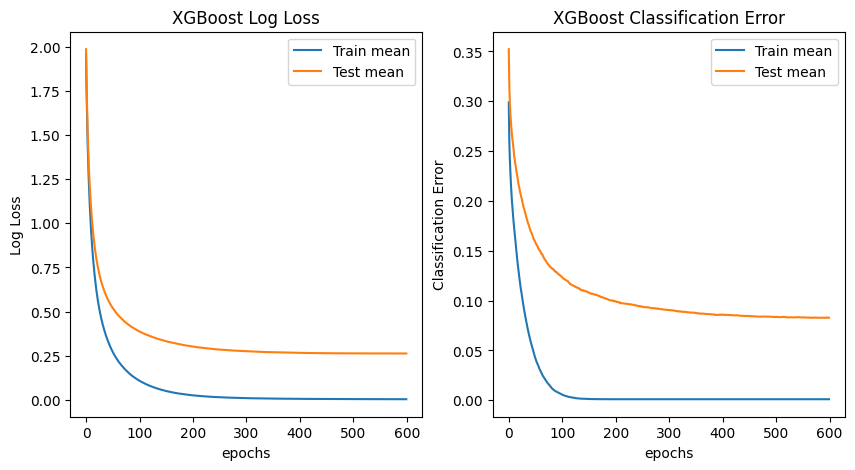

In [18]:
# XGboost CV驗證
dtrain = xgboost.DMatrix(X_sf, y_sf)  # 資料集 X, y無降維  ( X_t: 'TSNE', X_p: 'PCA') 
xgb_cv = xgboost.cv(dtrain=dtrain, params=params, nfold=5, num_boost_round=n, as_pandas=True)

#繪製學習曲線圖
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(xgb_cv['train-mlogloss-mean'], label='Train mean')
ax[0].plot(xgb_cv['test-mlogloss-mean'], label='Test mean')
ax[0].legend()
ax[0].set_title('XGBoost Log Loss')
ax[0].set_ylabel('Log Loss')
ax[0].set_xlabel('epochs')

ax[1].plot(xgb_cv['train-merror-mean'], label='Train mean')
ax[1].plot(xgb_cv['test-merror-mean'], label='Test mean')
ax[1].legend()
ax[1].set_title('XGBoost Classification Error')
ax[1].set_ylabel('Classification Error')
ax[1].set_xlabel('epochs')
plt.savefig(f'XGB_LearningCurve(600)_CV-{t}.png',dpi=100)

In [10]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(RandomForestClassifier(n_estimators=500, max_depth=8, max_features="auto"), 
                                                        X=X_sf, 
                                                        y=y_sf,
                                                        # Number of folds in cross-validation
                                                        cv=5,
                                                        # Evaluation metric
                                                        scoring='accuracy',
                                                        #scoring='neg_mean_squared_log_erro',
                                                        # Use all computer cores
                                                        n_jobs=-1,
                                                        # 50 different sizes of the training set
                                                        #shuffle=True,
                                                        train_sizes=np.linspace(0.1, 1, 5))
                   
# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

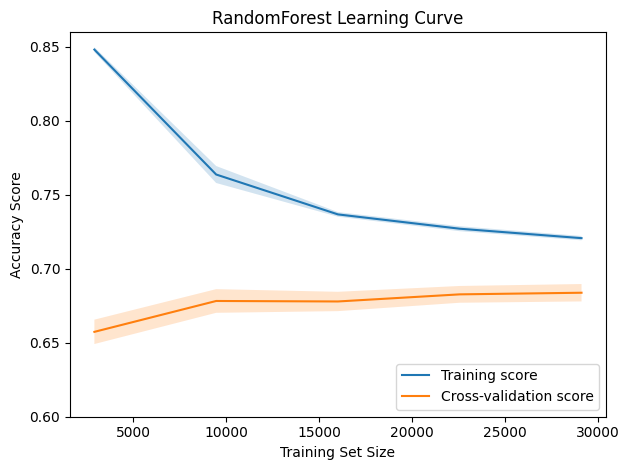

In [11]:
# Draw lines
plt.plot(train_sizes, train_mean, label="Training score")  #color="#111111"
plt.plot(train_sizes, test_mean, label="Cross-validation score") #color="#111111"
# plt.plot(train_sizes, test_scores[-1],'--', label="Desired score") #color="#111111"

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2)
# Create plot
plt.title("RandomForest Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score")
plt.legend(loc=4, markerscale=1)
plt.ylim(0.6)
plt.tight_layout()
plt.savefig(f'RF_LearningCurve-{t}.png',dpi=100)
plt.show()

In [12]:
train_sizes, train_loss, test_loss = learning_curve(KNeighborsClassifier(n_neighbors=5), 
                                                        X=X_sf, 
                                                        y=y_sf,
                                                        # Number of folds in cross-validation
                                                        cv=5,
                                                        # Evaluation metric
                                                        scoring='accuracy',
                                                        #scoring='neg_mean_squared_log_error',
                                                        # Use all computer cores
                                                        n_jobs=-1,
                                                        # 50 different sizes of the training set
                                                        #shuffle=True,
                                                        train_sizes=np.linspace(0.1, 1, 5))
                                    
# Create means and standard deviations of training set scores
train_mean = np.mean(train_loss, axis=1)
train_std = np.std(train_loss, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_loss, axis=1)
test_std = np.std(test_loss, axis=1)

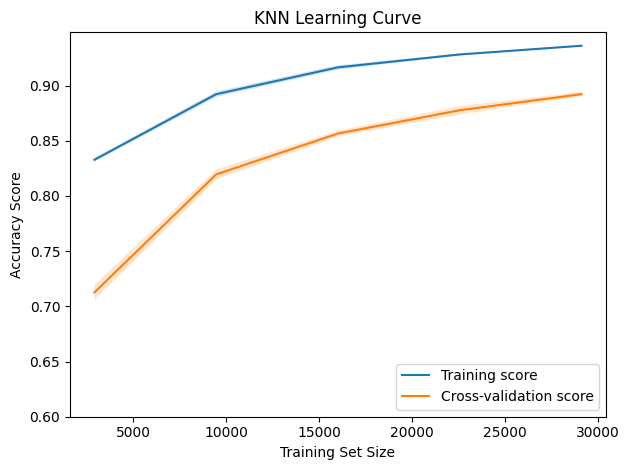

In [13]:
# Draw lines
plt.plot(train_sizes, train_mean,  label="Training score")
plt.plot(train_sizes, test_mean, label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2)

plt.title("KNN Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score")
plt.legend(loc=4, markerscale=1)
plt.ylim(0.6)
plt.tight_layout()
plt.savefig(f'KNN_LearningCurve-{t}.png',dpi=100)
plt.show()

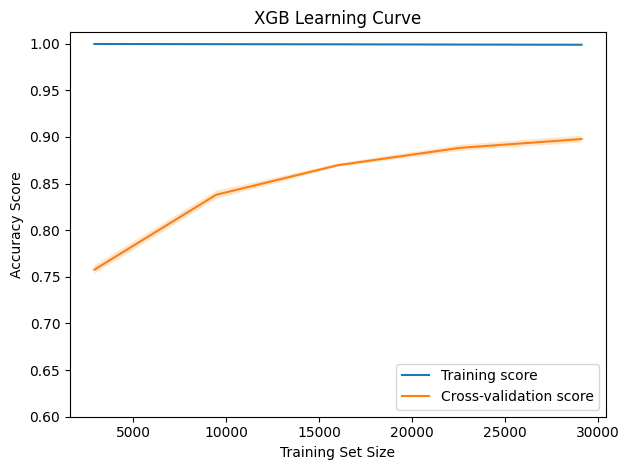

In [14]:
train_sizes, train_scores, test_scores = learning_curve(XGBClassifier(params=params),
                                                        X=X_sf, 
                                                        y=y_sf,
                                                        # Number of folds in cross-validation
                                                        cv=5,
                                                        # Evaluation metric
#                                                         scoring='accuracy',
#                                                         scoring='neg_brier_score',
                                                        # Use all computer cores
                                                        n_jobs=-1,
                                                        # 50 different sizes of the training set
#                                                         shuffle=True,           
                                                        train_sizes=np.linspace(0.1, 1, 5))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, label="Training score")
plt.plot(train_sizes, test_mean, label="Cross-validation score")
# plt.plot(train_sizes, test_scores[-1],'--', label="Desired score") #color="#111111"

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2)

# Create plot
plt.title("XGB Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score")
plt.legend(loc=4, markerscale=1)
plt.ylim(0.6)
plt.tight_layout()
plt.savefig(f'XGB_LearningCurve-{t}.png', dpi=100)
plt.show()

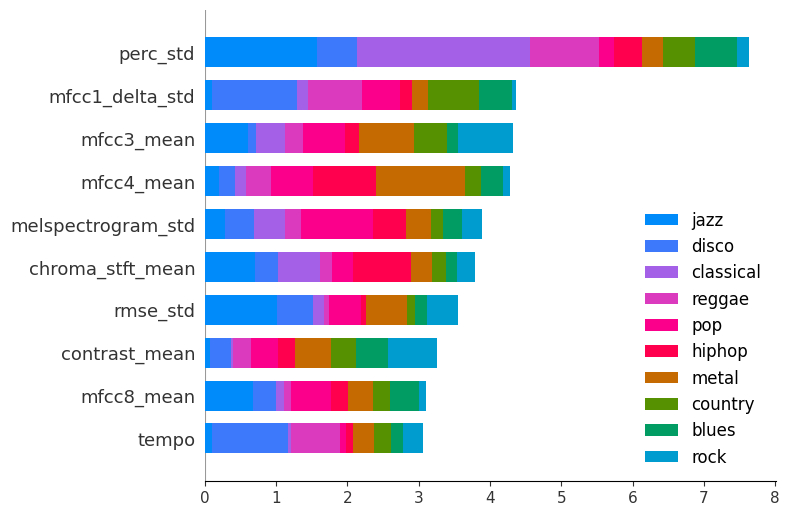

In [26]:
# 特徵重要性圖
import shap
plt.figure(figsize = (16, 10))
class_names = {0:"blues", 1:"classical", 2:"country", 3:"disco", 4:"hiphop", 5:"jazz", 6:"metal", 7:"pop", 8:"reggae", 9:"rock"}
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, feature_names=X.columns, class_names=class_names, max_display=10, show=False)
plt.xlabel("")
plt.savefig(f'XGB_Explainer_plot-{t}.png',dpi=100)

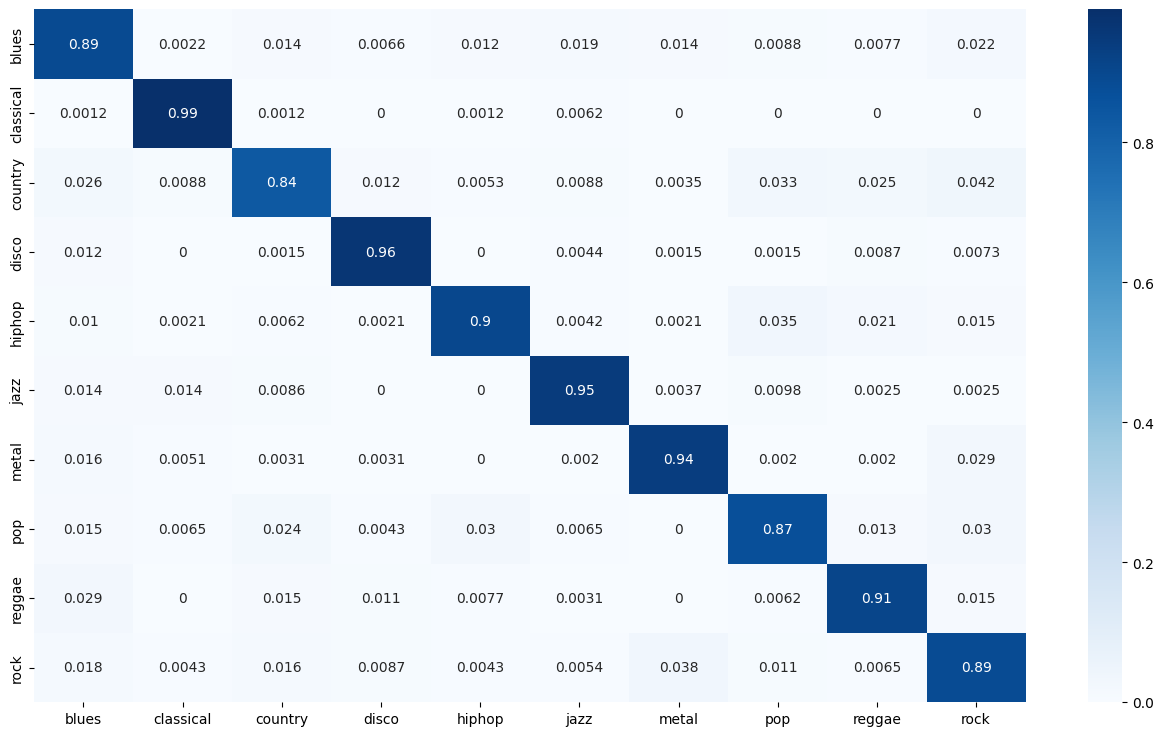

In [25]:
# Confusion Matrix
confusion_matr = confusion_matrix(y_test, preds ,normalize = 'true')
plt.figure(figsize = (16, 9))
sns.heatmap(confusion_matr, cmap="Blues", annot=True, 
            xticklabels = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"],
            yticklabels = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]);
plt.savefig(f"XGB_conf_matrix-{t}.png", dpi=100, transparent=True)